In [1]:
import pandas as pd
import numpy as np
import string

In [2]:
products = pd.read_csv('amazon_baby_subset.csv')

In [3]:
products['name'].head(10).values

array(["Stop Pacifier Sucking without tears with Thumbuddy To Love's Binky Fairy Puppet and Adorable Book",
       "Nature's Lullabies Second Year Sticker Calendar",
       "Nature's Lullabies Second Year Sticker Calendar",
       'Lamaze Peekaboo, I Love You',
       "SoftPlay Peek-A-Boo Where's Elmo A Children's Book",
       'Our Baby Girl Memory Book',
       'Hunnt&reg; Falling Flowers and Birds Kids Nursery Home Decor Vinyl Mural Art Wall Paper Stickers',
       'Blessed By Pope Benedict XVI Divine Mercy Full Color Medal',
       'Cloth Diaper Pins Stainless Steel Traditional Safety Pin (Black)',
       'Cloth Diaper Pins Stainless Steel Traditional Safety Pin (Black)'],
      dtype=object)

In [4]:
products.columns.values

array(['name', 'review', 'rating', 'sentiment'], dtype=object)

In [5]:
def remove_punctuation(text):
    table = str.maketrans({key: None for key in string.punctuation})
    return text.translate(table) 

In [6]:
products = products.fillna({'review':''})

In [7]:
products['review_clean'] = products['review'].apply(remove_punctuation)

In [8]:
important_words = pd.read_json('important_words.json')

In [9]:
important_words = important_words[0].tolist()

In [10]:
for word in important_words:
    products[word] = products['review_clean'].apply(lambda s : s.split().count(word))

In [11]:
train = pd.read_json('module-4-assignment-train-idx.json')
validation = pd.read_json('module-4-assignment-validation-idx.json')

In [12]:
def get_numpy_data(dataframe, features, label):
    dataframe['constant'] = 1
    features = ['constant'] + features
    features_frame = dataframe[features]
    feature_matrix = features_frame.as_matrix()
    label_sarray = dataframe[label]
    label_array = label_sarray.as_matrix()
    return(feature_matrix, label_array)

In [13]:
feature_matrix, sentiment = get_numpy_data(products, important_words, 'sentiment')

/Users/mac/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """
/Users/mac/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys


In [14]:
train_data = products.iloc[train[0].tolist()]
validation_data = products.iloc[validation[0].tolist()]

In [15]:
feature_matrix_train, sentiment_train = get_numpy_data(train_data, important_words, 'sentiment')
feature_matrix_valid, sentiment_valid = get_numpy_data(validation_data, important_words, 'sentiment') 

/Users/mac/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/mac/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """
/Users/mac/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys


In [16]:
'''
produces probablistic estimate for P(y_i = +1 | x_i, w).
estimate ranges between 0 and 1.
'''
def predict_probability(feature_matrix, coefficients):
    # Take dot product of feature_matrix and coefficients  
    # YOUR CODE HERE
    score = np.dot(feature_matrix, coefficients)
    
    # Compute P(y_i = +1 | x_i, w) using the link function
    # YOUR CODE HERE
    predictions = 1/(1+np.exp(-score))
    
    # return predictions
    return predictions

In [17]:
def feature_derivative_with_L2(errors, feature, coefficient, l2_penalty, feature_is_constant): 
    
    # Compute the dot product of errors and feature
    ## YOUR CODE HERE
    derivative =  np.dot(feature, errors)

    # add L2 penalty term for any feature that isn't the intercept.
    if not feature_is_constant: 
        ## YOUR CODE HERE
        derivative =  derivative - 2*l2_penalty*coefficient
        
    return derivative

In [18]:
def compute_log_likelihood_with_L2(feature_matrix, sentiment, coefficients, l2_penalty):
    indicator = (sentiment==+1)
    scores = np.dot(feature_matrix, coefficients)
    
    lp = np.sum((indicator-1)*scores - np.log(1. + np.exp(-scores))) - l2_penalty*np.sum(coefficients[1:]**2)
    
    return lp

In [19]:
def logistic_regression_with_L2(feature_matrix, sentiment, initial_coefficients, step_size, l2_penalty, max_iter):
    coefficients = np.array(initial_coefficients) # make sure it's a numpy array
    for itr in range(max_iter):
        # Predict P(y_i = +1|x_i,w) using your predict_probability() function
        ## YOUR CODE HERE
        predictions = predict_probability(feature_matrix,coefficients)
        
        # Compute indicator value for (y_i = +1)
        indicator = (sentiment==+1)
        
        # Compute the errors as indicator - predictions
        errors = indicator - predictions
        for j in range(len(coefficients)): # loop over each coefficient
            is_intercept = (j == 0)
            # Recall that feature_matrix[:,j] is the feature column associated with coefficients[j].
            # Compute the derivative for coefficients[j]. Save it in a variable called derivative
            ## YOUR CODE HERE
            derivative = feature_derivative_with_L2(errors, feature_matrix[:,j], coefficients[j], l2_penalty, is_intercept)
            
            # add the step size times the derivative to the current coefficient
            ## YOUR CODE HERE
            coefficients[j] += step_size*derivative
        
        # Checking whether log likelihood is increasing
        if itr <= 15 or (itr <= 100 and itr % 10 == 0) or (itr <= 1000 and itr % 100 == 0) \
        or (itr <= 10000 and itr % 1000 == 0) or itr % 10000 == 0:
            lp = compute_log_likelihood_with_L2(feature_matrix, sentiment, coefficients, l2_penalty)
            print('iteration %*d: log likelihood of observed labels = %.8f' % \
                (int(np.ceil(np.log10(max_iter))), itr, lp))
    return coefficients

In [20]:
coefficients_0_penalty = logistic_regression_with_L2(feature_matrix, sentiment, [0.0]*194, 5e-6, 0,501)

iteration   0: log likelihood of observed labels = -36501.00077248
iteration   1: log likelihood of observed labels = -36229.58317077
iteration   2: log likelihood of observed labels = -35970.75464027
iteration   3: log likelihood of observed labels = -35723.33008776
iteration   4: log likelihood of observed labels = -35486.40885733
iteration   5: log likelihood of observed labels = -35259.25616861
iteration   6: log likelihood of observed labels = -35041.24136548
iteration   7: log likelihood of observed labels = -34831.80501055
iteration   8: log likelihood of observed labels = -34630.44072328
iteration   9: log likelihood of observed labels = -34436.68462885
iteration  10: log likelihood of observed labels = -34250.10878417
iteration  11: log likelihood of observed labels = -34070.31672141
iteration  12: log likelihood of observed labels = -33896.94015489
iteration  13: log likelihood of observed labels = -33729.63636019
iteration  14: log likelihood of observed labels = -33568.0859

In [21]:
coefficients_4_penalty = logistic_regression_with_L2(feature_matrix, sentiment, [0.0]*194, 5e-6, 4, 501)

iteration   0: log likelihood of observed labels = -36501.00656331
iteration   1: log likelihood of observed labels = -36229.61671669
iteration   2: log likelihood of observed labels = -35970.83580141
iteration   3: log likelihood of observed labels = -35723.47695212
iteration   4: log likelihood of observed labels = -35486.63795719
iteration   5: log likelihood of observed labels = -35259.58264195
iteration   6: log likelihood of observed labels = -35041.67908879
iteration   7: log likelihood of observed labels = -34832.36671441
iteration   8: log likelihood of observed labels = -34631.13809561
iteration   9: log likelihood of observed labels = -34437.52840800
iteration  10: log likelihood of observed labels = -34251.10884313
iteration  11: log likelihood of observed labels = -34071.48214397
iteration  12: log likelihood of observed labels = -33898.27930440
iteration  13: log likelihood of observed labels = -33731.15694176
iteration  14: log likelihood of observed labels = -33569.7950

In [22]:
coefficients_10_penalty = logistic_regression_with_L2(feature_matrix, sentiment, [0.0]*194, 5e-6, 10, 501)

iteration   0: log likelihood of observed labels = -36501.01524956
iteration   1: log likelihood of observed labels = -36229.66703216
iteration   2: log likelihood of observed labels = -35970.95752672
iteration   3: log likelihood of observed labels = -35723.69720439
iteration   4: log likelihood of observed labels = -35486.98151526
iteration   5: log likelihood of observed labels = -35260.07218917
iteration   6: log likelihood of observed labels = -35042.33541276
iteration   7: log likelihood of observed labels = -34833.20888079
iteration   8: log likelihood of observed labels = -34632.18360335
iteration   9: log likelihood of observed labels = -34438.79332934
iteration  10: log likelihood of observed labels = -34252.60795023
iteration  11: log likelihood of observed labels = -34073.22902336
iteration  12: log likelihood of observed labels = -33900.28646044
iteration  13: log likelihood of observed labels = -33733.43589007
iteration  14: log likelihood of observed labels = -33572.3564

In [23]:
coefficients_1e2_penalty = logistic_regression_with_L2(feature_matrix, sentiment, [0.0]*194, 5e-6, 1e2, 501)

iteration   0: log likelihood of observed labels = -36501.14554336
iteration   1: log likelihood of observed labels = -36230.42127397
iteration   2: log likelihood of observed labels = -35972.78104800
iteration   3: log likelihood of observed labels = -35726.99461905
iteration   4: log likelihood of observed labels = -35492.12169965
iteration   5: log likelihood of observed labels = -35267.39200906
iteration   6: log likelihood of observed labels = -35052.14279454
iteration   7: log likelihood of observed labels = -34845.78548413
iteration   8: log likelihood of observed labels = -34647.78720696
iteration   9: log likelihood of observed labels = -34457.65998114
iteration  10: log likelihood of observed labels = -34274.95390994
iteration  11: log likelihood of observed labels = -34099.25251762
iteration  12: log likelihood of observed labels = -33930.16926765
iteration  13: log likelihood of observed labels = -33767.34477085
iteration  14: log likelihood of observed labels = -33610.4444

In [24]:
coefficients_1e3_penalty = logistic_regression_with_L2(feature_matrix, sentiment, [0.0]*194, 5e-6, 1e3, 501)

iteration   0: log likelihood of observed labels = -36502.44848131
iteration   1: log likelihood of observed labels = -36237.91326742
iteration   2: log likelihood of observed labels = -35990.77488321
iteration   3: log likelihood of observed labels = -35759.32015854
iteration   4: log likelihood of observed labels = -35542.18735471
iteration   5: log likelihood of observed labels = -35338.23193730
iteration   6: log likelihood of observed labels = -35146.45618582
iteration   7: log likelihood of observed labels = -34965.97071535
iteration   8: log likelihood of observed labels = -34795.97212805
iteration   9: log likelihood of observed labels = -34635.72897289
iteration  10: log likelihood of observed labels = -34484.57211081
iteration  11: log likelihood of observed labels = -34341.88752301
iteration  12: log likelihood of observed labels = -34207.11056476
iteration  13: log likelihood of observed labels = -34079.72114818
iteration  14: log likelihood of observed labels = -33959.2395

In [25]:
coefficients_1e5_penalty = logistic_regression_with_L2(feature_matrix, sentiment, [0.0]*194, 5e-6, 1e5, 501)

iteration   0: log likelihood of observed labels = -36645.77165560
iteration   1: log likelihood of observed labels = -36645.49154027
iteration   2: log likelihood of observed labels = -36645.43428902
iteration   3: log likelihood of observed labels = -36645.39141083
iteration   4: log likelihood of observed labels = -36645.35398921
iteration   5: log likelihood of observed labels = -36645.32091656
iteration   6: log likelihood of observed labels = -36645.29165939
iteration   7: log likelihood of observed labels = -36645.26577562
iteration   8: log likelihood of observed labels = -36645.24287619
iteration   9: log likelihood of observed labels = -36645.22261698
iteration  10: log likelihood of observed labels = -36645.20469360
iteration  11: log likelihood of observed labels = -36645.18883672
iteration  12: log likelihood of observed labels = -36645.17480809
iteration  13: log likelihood of observed labels = -36645.16239692
iteration  14: log likelihood of observed labels = -36645.1514

In [26]:
table = pd.DataFrame({'word':['intercept']+important_words})

In [27]:
table

,word
0,intercept
1,baby
2,one
3,great
4,love
5,use
6,would
7,like
8,easy
9,little


In [28]:
table['p0'] = coefficients_0_penalty
table['p4'] = coefficients_4_penalty
table['p10'] = coefficients_10_penalty
table['p1e2'] = coefficients_1e2_penalty
table['p1e3'] = coefficients_1e3_penalty
table['p1e5'] = coefficients_1e5_penalty
positive_words = table.sort_values('p0',ascending=False)['word'][0:5]
negative_words = table.sort_values('p0',ascending=True)['word'][0:5]


,word,p0,p4,p10,p1e2,p1e3,p1e5
3,great,0.830302,0.825785,0.819134,0.734553,0.417318,0.011273
34,perfect,0.930688,0.922874,0.911364,0.765112,0.291294,0.004984
8,easy,1.022798,1.016033,1.006082,0.880706,0.449014,0.011007
4,love,1.096187,1.088644,1.077549,0.937865,0.464760,0.011230
23,loves,1.149917,1.140753,1.127262,0.956320,0.396036,0.007596


In [ ]:
table = table_positive_words + 

In [47]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 6

def make_coefficient_plot(table, positive_words, negative_words, l2_penalty_list):
    cmap_positive = plt.get_cmap('Reds')
    cmap_negative = plt.get_cmap('Blues')
    
    xx = l2_penalty_list
    plt.plot(xx, [0.]*len(xx), '--', lw=1, color='k')
    
    table_positive_words = table[table['word'].isin(positive_words)]
    table_negative_words = table[table['word'].isin(negative_words)]
    del table_positive_words['word']
    del table_negative_words['word']
    
    for i in range(len(positive_words)):
        color = cmap_positive(0.8*((i+1)/(len(positive_words)*1.2)+0.15))
        plt.plot(xx, table_positive_words[i:i+1].as_matrix().flatten(),'-', label=positive_words.iloc[:i], linewidth=4.0, color=color)
        
    for i in range(len(negative_words)):
        color = cmap_negative(0.8*((i+1)/(len(negative_words)*1.2)+0.15))
        plt.plot(xx, table_negative_words[i:i+1].as_matrix().flatten(),'-', label=negative_words.iloc[:i], linewidth=4.0, color=color)
        
    plt.legend(loc='best', ncol=3, prop={'size':6}, columnspacing=0.5)
    plt.axis([1, 1e5, -1, 2])
    plt.title('Coefficient path')
    plt.xlabel('L2 penalty ($\lambda$)')
    plt.ylabel('Coefficient value')
    plt.xscale('log')
    plt.rcParams.update({'font.size': 18})
    plt.tight_layout()


/Users/mac/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/mac/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


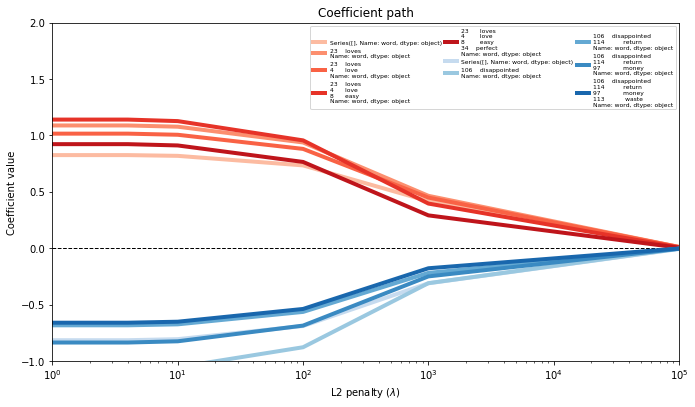

In [48]:
make_coefficient_plot(table, positive_words, negative_words, l2_penalty_list=[0, 4, 10, 1e2, 1e3, 1e5])

In [49]:
predict0 = predict_probability(feature_matrix_train, coefficients_0_penalty)
predict4 = predict_probability(feature_matrix_train, coefficients_4_penalty)
predict10 = predict_probability(feature_matrix_train, coefficients_10_penalty)
predict100 = predict_probability(feature_matrix_train, coefficients_1e2_penalty)
predictle3 = predict_probability(feature_matrix_train, coefficients_1e3_penalty)
predictle5 = predict_probability(feature_matrix_train, coefficients_1e5_penalty)

In [81]:
predict0 = (predict0>0.5)*1
predict0[predict0 == 0] = -1

predict4 = (predict4>0.5)*1
predict4[predict4 == 0] = -1

predict10 = (predict10>0.5)*1
predict10[predict10 == 0] = -1

predict100 = (predict100>0.5)*1
predict100[predict100 == 0] = -1

predictle3 = (predictle3>0.5)*1
predictle3[predictle3 == 0] = -1

predictle5 = (predictle5>0.5)*1
predictle5[predictle5 == 0] = -1

In [82]:
train_data['coefficients_0_penalty'] = predict0
train_data['coefficients_4_penalty'] = predict4
train_data['coefficients_10_penalty'] = predict10
train_data['coefficients_1e2_penalty'] = predict100
train_data['coefficients_1e3_penalty'] = predictle3
train_data['coefficients_1e5_penalty'] = predictle5

/Users/mac/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/mac/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/mac/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

In [83]:
print(sum(train_data['coefficients_0_penalty']==train_data['sentiment'])/len(train_data))
print(sum(train_data['coefficients_4_penalty']==train_data['sentiment'])/len(train_data))
print(sum(train_data['coefficients_10_penalty']==train_data['sentiment'])/len(train_data))
print(sum(train_data['coefficients_1e2_penalty']==train_data['sentiment'])/len(train_data))
print(sum(train_data['coefficients_1e3_penalty']==train_data['sentiment'])/len(train_data))
print(sum(train_data['coefficients_1e5_penalty']==train_data['sentiment'])/len(train_data))

0.7867378012794788
0.7866433748022945
0.7865017350865182
0.7851089445480512
0.7753830173980785
0.7149972852387809


In [84]:
predict0 = predict_probability(feature_matrix_valid, coefficients_0_penalty)
predict4 = predict_probability(feature_matrix_valid, coefficients_4_penalty)
predict10 = predict_probability(feature_matrix_valid, coefficients_10_penalty)
predict100 = predict_probability(feature_matrix_valid, coefficients_1e2_penalty)
predictle3 = predict_probability(feature_matrix_valid, coefficients_1e3_penalty)
predictle5 = predict_probability(feature_matrix_valid, coefficients_1e5_penalty)

predict0 = (predict0>0.5)*1
predict0[predict0 == 0] = -1

predict4 = (predict4>0.5)*1
predict4[predict4 == 0] = -1

predict10 = (predict10>0.5)*1
predict10[predict10 == 0] = -1

predict100 = (predict100>0.5)*1
predict100[predict100 == 0] = -1

predictle3 = (predictle3>0.5)*1
predictle3[predictle3 == 0] = -1

predictle5 = (predictle5>0.5)*1
predictle5[predictle5 == 0] = -1

validation_data['coefficients_0_penalty'] = predict0
validation_data['coefficients_4_penalty'] = predict4
validation_data['coefficients_10_penalty'] = predict10
validation_data['coefficients_1e2_penalty'] = predict100
validation_data['coefficients_1e3_penalty'] = predictle3
validation_data['coefficients_1e5_penalty'] = predictle5

print(sum(validation_data['coefficients_0_penalty']==validation_data['sentiment'])/len(validation_data))
print(sum(validation_data['coefficients_4_penalty']==validation_data['sentiment'])/len(validation_data))
print(sum(validation_data['coefficients_10_penalty']==validation_data['sentiment'])/len(validation_data))
print(sum(validation_data['coefficients_1e2_penalty']==validation_data['sentiment'])/len(validation_data))
print(sum(validation_data['coefficients_1e3_penalty']==validation_data['sentiment'])/len(validation_data))
print(sum(validation_data['coefficients_1e5_penalty']==validation_data['sentiment'])/len(validation_data))


0.7856409298851648
0.7857342918495005
0.785547567920829
0.7848006722061432
0.7758379236299132
0.7053496405564373


/Users/mac/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/mac/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/mac/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/in